# Handling Missing data

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Dealing with missing data, when the order is not relevant

Frequently, when dealing with missing data, the sequencing does not matter, and thus, the values used to replace missing values can be based on the entirety of available data. In such cases, you would typically replace the missing values with your best guess (i.e., mean or medium of the available data)
Let’s quickly go over why you should use this option with care. Let’s assume you survey 1000 boys and 1000 girls for their weights. During the process of collecting the data, unfortunately, some of the data went missing.

In [2]:
# sample 1000 boys and 1000 girls
boys = np.random.normal(70,5,1000)
girls = np.random.normal(50,3,1000)

# unfortunately, the intern running the survey on the girls got distracted and lost 100 samples
for i in range(100):
    girls[np.random.randint(0,1000)] = np.nan
    
# build DataFrame
boys = pd.DataFrame(boys, columns=['weight'])
boys['gender'] = 'boy'
girls = pd.DataFrame(girls, columns=['weight'])
girls['gender'] = 'girl'
df = pd.concat([girls,boys],axis=0)
df['weight'] = df['weight'].astype(float)

In [4]:
df.head()

,weight,gender
0,54.820492,girl
1,46.712157,girl
2,50.274107,girl
3,58.108953,girl
4,52.149211,girl


In [5]:
df.isna().sum()

weight    94
gender     0
dtype: int64

### One sub-group

Without giving it much thought, we might fill the missing values with the entire sample’s mean. The results look somewhat strange, though. The girl’s KDE has two humps. One might conclude that there is a subgroup of heavier girls among our sample. Because we built the distributions beforehand, we know this isn’t the case. But if this were real data, we might draw wrong conclusions from this data.

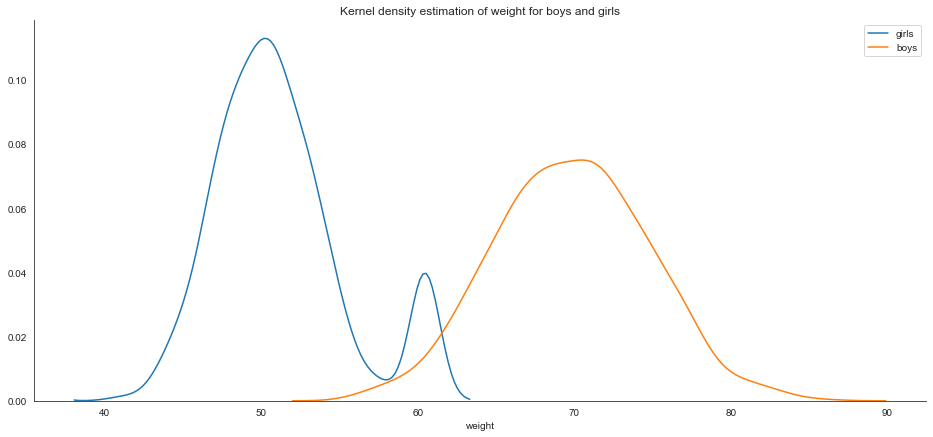

In [10]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16, 7))
mean = df['weight'].mean()

sns.distplot(
    df[df['gender'] == 'girl']['weight'].fillna(mean),
    kde=True,
    hist=False,
    ax=ax,
    label='girls'
)
sns.distplot(
    df[df['gender'] == 'boy']['weight'],
    kde=True,
    hist=False,
    ax=ax,
    label='boys'
)
plt.title('Kernel density estimation of weight for boys and girls')
sns.despine()

#### Filling missing values with the group’s mean

In such situations, Panda’s transform function comes in handy. Using transform gives a convenient way of fixing the problem on a group level like this:

In [11]:
df['filled_weight'] = df.groupby('gender')['weight'].transform(
    lambda x: x.fillna(np.mean(x))
)

Running the above command and plotting the KDE of the filled_weight values results in:

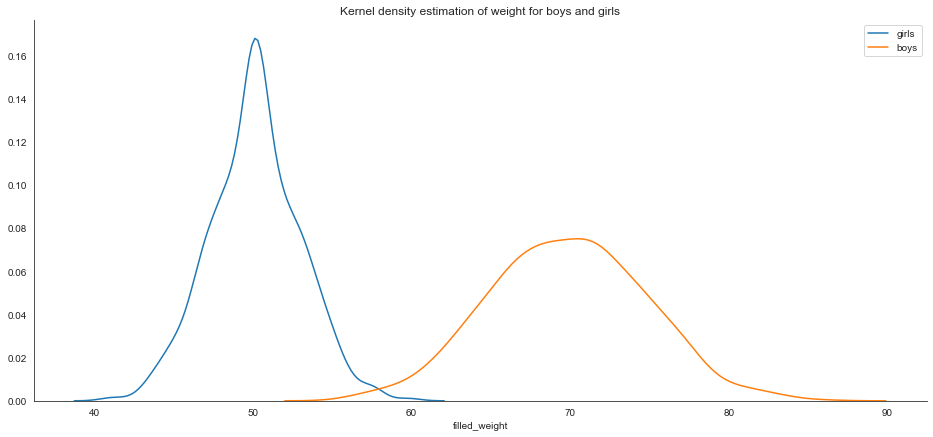

In [14]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16, 7))
mean = df['weight'].mean()

sns.distplot(
    df[df['gender'] == 'girl']['filled_weight'],
    kde=True,
    hist=False,
    ax=ax,
    label='girls'
)
sns.distplot(
    df[df['gender'] == 'boy']['filled_weight'],
    kde=True,
    hist=False,
    ax=ax,
    label='boys'
)
plt.title('Kernel density estimation of weight for boys and girls')
sns.despine()

### Multiple sub-groups

Let’s use the previous example, but this time, we go a bit further and additionally segment our data into age groups. Let’s create some mock data:

In [15]:
# paramter for the weight distribution (mean, std)
param_map = {
    'boy':{
        '<10':(40,4),
        '<20':(60,4),
        '20+':(70,5),
    },
    'girl':{
        '<10':(30,2),
        '<20':(40,3),
        '20+':(50,3),
    }
}

# generate 10k records
df = pd.DataFrame({
    'gender':np.random.choice(['girl','boy'],10000),
    'age_cohort':np.random.choice(['<10','<20','20+'],10000)
})

# set random weight based on parameters
df['weight'] = df.apply(
    lambda x: np.random.normal(
        loc=param_map[x['gender']][x['age_cohort']][0],
        scale=param_map[x['gender']][x['age_cohort']][1]
    ),axis=1
)

# set 500 values missing
for i in range(500):
    df.loc[np.random.randint(0,len(df)),'weight'] = np.nan

In [17]:
df.head()

,gender,age_cohort,weight
0,girl,<10,30.444743
1,boy,20+,64.061090
2,girl,20+,51.959769
3,girl,20+,49.582732
4,girl,20+,50.564939


Plotting the data reveals somewhat strange bimodal distributions (code below).

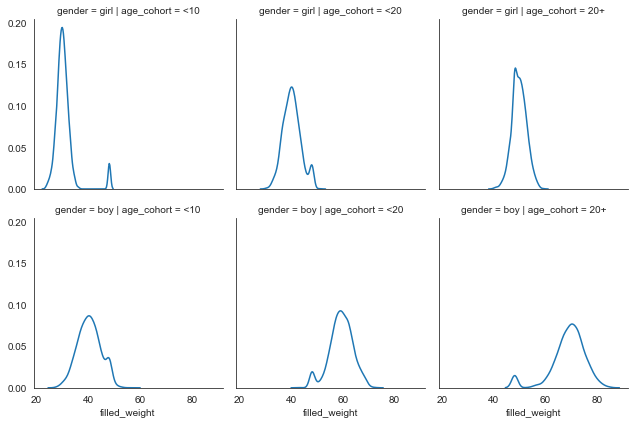

In [18]:
df['filled_weight'] = df['weight'].fillna(
    df['weight'].mean()
)
g = sns.FacetGrid(
    df,
    col='age_cohort',
    row='gender',
    col_order=['<10','<20','20+']
)
g.map(sns.kdeplot,'filled_weight')

Now, if we would only replace the missing values with the mean for the respective gender, this would not go far enough as not only boys and girls are different in weight, but also different age groups are quite different in weight.

**Luckily, transform can be applied just as before. We would group on both columns instead of only one like this:**

In [19]:
df['filled_weight'] = df.groupby(['gender','age_cohort'])['weight'].transform(
    lambda x: x.fillna(np.mean(x))
)

Running the above snippet will generate this much cleaner plot:


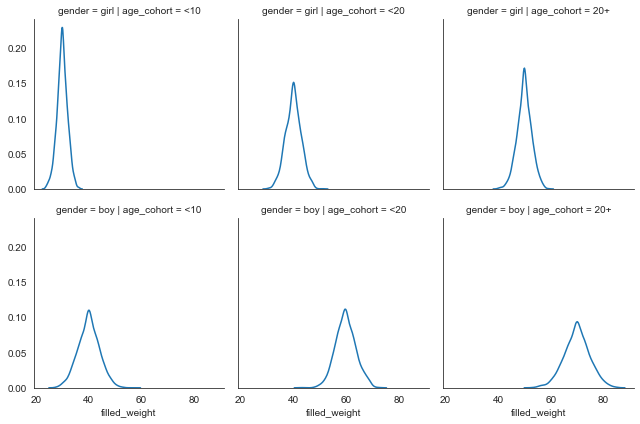

In [21]:
g = sns.FacetGrid(
    df,
    col='age_cohort',
    row='gender',
    col_order=['<10','<20','20+']
)
g.map(sns.kdeplot,'filled_weight')

## Dealing with missing data, when the order is relevant

**Two situations frequently come up when working with time-series data.**

**Aligning date ranges:**  Say you look at countries’ GDP, education level, and population growth by year. For some countries, you are missing the very first, some of the later years, or some years in between. Sure, you could ignore them. Still, for visualization purposes, you might want to keep them around and project your first observed value to the beginning, your last observed value to the end of your survey period, and come up with something that makes sense for the values in the middle.

**Interpolation:** Looking at time-series data interpolation and thus ordering becomes very relevant. Replacing missing stock data from 2012 with an average that is calculated based on data up to 2019 is bound to produce some wacky results.

We will look at an example based on data from the World Happiness Report 2019, where we address both situations. The World Happiness Report tries to answer which factors influence happiness throughout the world. The report surveys data from the year 2005 to 2018.

In [22]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/FBosler/you-datascientist/master/happiness_with_continent.csv')

In [30]:
df.sample(5)

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Continent
1112,Niger,2016,4.234646,6.821260,0.682828,52.500000,0.701927,-0.002667,0.814494,0.674859,...,0.368750,0.474756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa
1207,Philippines,2008,4.589065,8.577242,0.798442,60.200001,0.860843,0.078335,0.816585,0.805394,...,NaN,NaN,NaN,NaN,NaN,0.055,0.082936,NaN,0.031518,Asia
48,Armenia,2008,4.651972,8.930409,0.709486,65.000000,0.462157,-0.201642,0.876099,0.520710,...,0.319250,NaN,NaN,NaN,NaN,0.235,NaN,NaN,0.109136,Asia
1295,Senegal,2007,4.679987,7.672032,0.718461,54.060001,0.698005,0.008652,0.826684,0.714047,...,0.402333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa
1282,Saudi Arabia,2007,7.266694,10.717305,0.891525,63.860001,0.622070,-0.012514,NaN,0.772243,...,NaN,NaN,NaN,NaN,NaN,NaN,0.505326,NaN,NaN,Asia


In [43]:
df.shape

(1704, 27)

In [24]:
df.isna().sum()

Country name                                                   0
Year                                                           0
Life Ladder                                                    0
Log GDP per capita                                            28
Social support                                                13
Healthy life expectancy at birth                              28
Freedom to make life choices                                  29
Generosity                                                    82
Perceptions of corruption                                     96
Positive affect                                               19
Negative affect                                               13
Confidence in national government                            174
Democratic Quality                                           146
Delivery Quality                                             145
Standard deviation of ladder by country-year                   0
Standard deviation/Mean o

In [29]:
df.dtypes

Country name                                                 object
Year                                                          int64
Life Ladder                                                 float64
Log GDP per capita                                          float64
Social support                                              float64
Healthy life expectancy at birth                            float64
Freedom to make life choices                                float64
Generosity                                                  float64
Perceptions of corruption                                   float64
Positive affect                                             float64
Negative affect                                             float64
Confidence in national government                           float64
Democratic Quality                                          float64
Delivery Quality                                            float64
Standard deviation of ladder by country-year    

**Let’s take a look at the number of countries per year we have data for.**

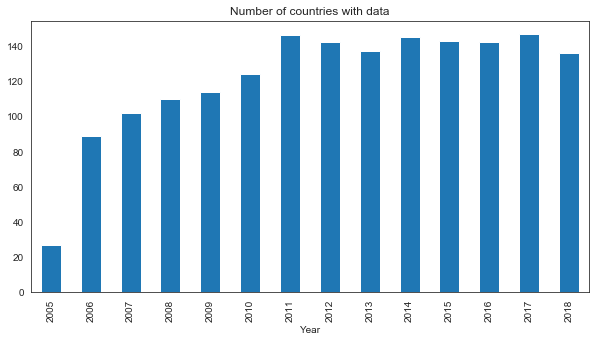

In [42]:
df.groupby(['Year']).size().plot(
    kind='bar',
    title='Number of countries with data',
    figsize=(10,5),
)

We can see that, especially for the earlier years, we don’t have many countries with data, and also there is some fluctuation across the entire sample period. 

**To mitigate the effect of missing data, we will do the following:**

1- Group by country and reindex to the whole date range

2- Interpolate for years between and extrapolate for years outside the range for which we have observations on a per-country basis

### 1. Group by country and reindex date range

In [44]:
# Define helper function
def add_missing_years(grp):
    _ = grp.set_index('Year')
    _ = _.reindex(list(range(2005,2019)))
    del _['Country name']
    return _

# Group by country name and extend
df = df.groupby('Country name').apply(add_missing_years)
df = df.reset_index()

In [47]:
df.shape

(2310, 27)

In [48]:
df.isna().sum()

Country name                                                   0
Year                                                           0
Life Ladder                                                  606
Log GDP per capita                                           634
Social support                                               619
Healthy life expectancy at birth                             634
Freedom to make life choices                                 635
Generosity                                                   688
Perceptions of corruption                                    702
Positive affect                                              625
Negative affect                                              619
Confidence in national government                            780
Democratic Quality                                           752
Delivery Quality                                             751
Standard deviation of ladder by country-year                 606
Standard deviation/Mean o

**We now have roughly 600 more rows. However, those observations are null right now**

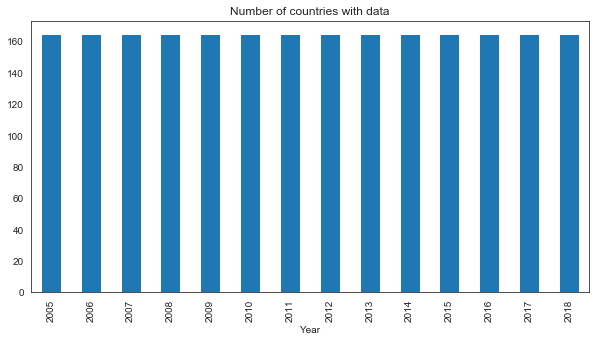

In [49]:
df.groupby(['Year']).size().plot(
    kind='bar',
    title='Number of countries with data',
    figsize=(10,5),
)

### 2. Interpolate for years between and extrapolate for years outside the range for which we have observations on a per-country basis

In [50]:
# Define helper function
def fill_missing(grp):
    res = grp.set_index('Year')\
    .interpolate(method='linear',limit=5)\
    .fillna(method='ffill')\
    .fillna(method='bfill')
    del res['Country name']
    return res

# Group by country name and fill missing
df = df.groupby(['Country name']).apply(
    lambda grp: fill_missing(grp)
)

df = df.reset_index()

The fill_missing function interpolates and extrapolates towards the end and the beginning, resulting in:

In [55]:
df.sample(10)

,Country name,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Continent
1989,Switzerland,2006,7.473253,10.906543,0.951352,71.540001,0.918958,0.285015,0.407931,0.821402,...,0.328100,0.322344,0.452701,NaN,0.265255,0.378479,NaN,0.518936,NaN,Europe
550,Denmark,2009,7.683359,10.677814,0.938892,70.239998,0.949336,0.259049,0.205770,0.748949,...,0.267000,0.504106,0.640332,NaN,NaN,NaN,NaN,NaN,NaN,Europe
2245,Venezuela,2010,7.478455,9.713838,0.931576,65.699997,0.768257,-0.166679,0.754269,0.861522,...,0.497167,0.313196,0.129567,NaN,NaN,0.133333,0.158333,NaN,NaN,South America
1351,Moldova,2012,5.995713,8.330985,0.826220,61.939999,0.602419,-0.002011,0.955485,0.567697,...,0.326059,0.375586,0.125844,NaN,NaN,0.218496,0.141357,0.175908,NaN,Europe
696,Gabon,2015,4.661013,9.731321,0.755862,58.200001,0.671301,-0.211467,0.866777,0.626362,...,0.422000,0.496453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa
797,Guinea,2018,5.252227,7.633718,0.630433,54.400002,0.731157,0.100011,0.778394,0.743881,...,0.387000,0.603388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa
263,Botswana,2016,3.498937,9.663145,0.768303,57.500000,0.851695,-0.258512,0.729172,0.685667,...,0.626000,0.658420,0.086772,NaN,NaN,NaN,NaN,NaN,NaN,Africa
542,Czech Republic,2015,6.608017,10.328933,0.911363,68.800003,0.808484,-0.147830,0.886467,0.750774,...,0.264167,0.265170,0.274264,NaN,0.302275,0.285192,NaN,NaN,NaN,Europe
200,Benin,2009,3.734853,7.514472,0.414080,51.260001,0.730624,-0.027158,0.833321,0.597689,...,0.432667,0.355524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Africa
62,Argentina,2011,6.775805,9.884781,0.889073,67.480003,0.815802,-0.170262,0.754646,0.840048,...,0.460938,0.347596,0.228952,0.270073,0.223553,0.170844,0.150154,0.174058,0.193531,South America


### **Perfect!**

Now we have data for the years 2005 to 2018 for all countries in our sample. The above methods were quite relevant for me when writing this article about visualizations. Check it out if you want to learn more about the happiness report.

In [56]:
df.to_csv('/Users/abreualberto91/Desktop/PYTHON/datasets/happy.csv', encoding='utf-8', index=False)